# Credits

This is heavily influenced from https://github.com/pytorch/tutorials

# CIFAR-10

In thins notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.
The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


In order to train a classifier the following steps needs to be performed:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

We will help you along the way.
We indicate the places you need to modify the code with `# Your code here!`.
It is however a good idea to read the entire assignment before you begin coding!

## 1. Loading and normalizing CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1]

**NB** Modify the code below to only use a small part of the dataset if your computer is very slow.

In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),
                          (0.5, 0.5, 0.5))]
)

# Load dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

used_categories = range(len(classes))

## USE CODE BELOW IF YOUR COMPUTER IS TOO SLOW
reduce_dataset = True
if reduce_dataset:
    used_categories = (3, 5) # cats and dogs

    classes = [classes[i] for i in used_categories]
    new_train_data = []
    new_train_labels = []

    new_test_data = []
    new_test_labels = []
    for i, t in enumerate(used_categories):
        new_train_data.append(trainset.data[np.where(np.array(trainset.targets) == t)])
        new_train_labels += [i for _ in range(new_train_data[-1].shape[0])]

        new_test_data.append(testset.data[np.where(np.array(testset.targets) == t)])
        new_test_labels += [i for _ in range(new_test_data[-1].shape[0])]

    new_train_data = np.concatenate(new_train_data, 0)
    trainset.data = new_train_data#.reshape((10000, 3, 32, 32))
    trainset.targets = new_train_labels
#    trainset.data = np.resize(trainset.data)

    new_test_data = np.concatenate(new_test_data, 0)
    testset.data = new_test_data
    testset.targets = new_test_labels
#    testset.data = testset.data.reshape((2000, 3, 32, 32))
#    testset.data = np.moveaxis(testset.data, [-1, 1], [1, -1])
#    testset.data = np.moveaxis(testset.data, [-1, -2], [-2, -1])
    
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2) # trainset is a torch feature
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)
train_data_iter = iter(trainloader)
test_data_iter = iter(testloader)
print('used classes:', classes)

Files already downloaded and verified
Files already downloaded and verified
used classes: ['cat', 'dog']


In [13]:
print("Training data")
print(trainset.data.shape)
print(len(trainset.targets))
print()

print("Test data")
print(testset.data.shape)
print(len(testset.targets))
print()

Training data
(10000, 32, 32, 3)
10000

Test data
(2000, 32, 32, 3)
2000



Let us show some of the training images, for fun.



  car   car   car   car


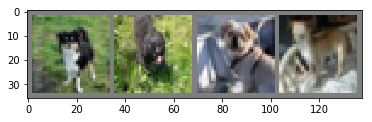

In [14]:
# Run this cell multiple time to see more samples
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    """ show an image """
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
images, labels = train_data_iter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolutional Neural Network

**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully come back and improve the architecture

In [15]:
# Understanding the shape
trainset.data.shape
# 10.000 pictures, 32x32 pixels, 3 colors (so all colors)

(10000, 32, 32, 3)

In [16]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

# hyperameters of the model
num_classes = 10
channels = trainset.data.shape[1]
height = trainset.data.shape[2]
width = trainset.data.shape[3] 
num_filters_conv1 = 16
kernel_size_conv1 = 5 # [height, width]
stride_conv1 = 1 # [stride_height, stride_width]
num_l1 = 100
padding_conv1 = 2 # so we keep dim 32x32
   
def compute_conv_dim(dim_size):
    return int((dim_size - kernel_size_conv1 + 2*padding_conv1) / stride_conv1 + 1)
# Function from https://pytorch.org/docs/stable/nn.html?highlight=conv2d#torch.nn.Conv2d (for me)

# define network
class Net(nn.Module):

    def __init__(self):
        # Convolution 
        super(Net, self).__init__()
        out_dim = (height - kernel_size_conv1 + 2*padding_conv1) / stride_conv1 + 1 # Adding 0's as padding round the pic to avoid dim loss 
        self.conv_1 = Conv2d(in_channels=channels,
                            out_channels=num_filters_conv1,
                            kernel_size=kernel_size_conv1,
                            stride=stride_conv1,
                            padding = padding_conv1)      # 3 channels in, output channel pr filter
                            # This gives our ned 3D matrix if we have added the padding (we have here)
        
        self.conv_out_height = compute_conv_dim(height) # The height and with we get from computing the formula from the website
        self.conv_out_width = compute_conv_dim(width)
        
        # add dropout to network
        self.dropout = Dropout2d(p=0.5)
        self.l1_in_features = num_filters_conv1 * self.conv_out_height * self.conv_out_width
        #self.l1_in_features = num_filters_conv1 * 32 * 32 # So our vector has the correct dim (32x32)
        self.l_1 = Linear(in_features=self.l1_in_features, 
                          out_features=num_l1,
                          bias=True)
        self.l_out = Linear(in_features=num_l1, 
                            out_features=num_classes,
                            bias=False)
    
    def forward(self, x): # x.size() = [batch, channel, height, width]
        x = x.type(torch.FloatTensor)
        x = relu(self.conv_1(x))
        # torch.Tensor.view: http://pytorch.org/docs/master/tensors.html?highlight=view#torch.Tensor.view
        #   Returns a new tensor with the same data as the self tensor,
        #   but of a different size.
        # the size -1 is inferred from other dimensions 
        x = x.view(-1, self.l1_in_features)
        #x = self.dropout(relu(self.l_1(x)))
        x = relu(self.l_1(x))
        return softmax(self.l_out(x), dim=1)


net = Net()
print(net)

Net(
  (conv_1): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (l_1): Linear(in_features=1536, out_features=100, bias=True)
  (l_out): Linear(in_features=100, out_features=10, bias=False)
)


In [17]:
# We test with dummy data! 
x = np.random.normal(0,1, (10000, 32, 32, 3)).astype('float32')
out = net(Variable(torch.from_numpy(x)))
out.size(), out

(torch.Size([10000, 10]),
 tensor([[0.0951, 0.1022, 0.1029,  ..., 0.0923, 0.0972, 0.0930],
         [0.1027, 0.1087, 0.0957,  ..., 0.0995, 0.0949, 0.0979],
         [0.1064, 0.1037, 0.1034,  ..., 0.0944, 0.0966, 0.0868],
         ...,
         [0.0974, 0.1082, 0.0950,  ..., 0.1064, 0.1005, 0.0948],
         [0.0999, 0.1005, 0.0954,  ..., 0.0997, 0.0964, 0.0904],
         [0.1012, 0.1001, 0.1037,  ..., 0.1027, 0.0965, 0.0962]],
        grad_fn=<SoftmaxBackward>))

## 3. Define a Loss function and optimizer

**Assignment 2:** Implement the criterion and optimizer. 
We suggest Classification Cross-Entropy loss and SGD with momentum.
You might need to experiment a bit with the learning rate.

In [ ]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9) 
criterion = nn.CrossEntropyLoss() 

## 4. Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 3).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [10]:
### NOTE TO READER ###
# My computer couldnt manage to run the program and finish the training, 
# but I'm fairly confident the code itself is working. For the same reason, 
# the next assignment on improving the model has not been made.

from sklearn.metrics import accuracy_score

batch_size = 9
num_epoch = 3  # Initializing on this
num_samples_train = trainset.data.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = testset.data.shape[0]
num_batches_valid = num_samples_valid // batch_size


train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

trainset.targets = np.asarray(trainset.targets, dtype = 'uint8')
testset.targets = np.asarray(testset.targets, dtype = 'uint8')

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad() #my code

        # forward + backward + optimize parameters
        ## Train
        cur_loss = 0
        net.train()
        
        for i in range(num_batches_train): # Forward propagation which we made with net
            slce = get_slice(i, batch_size)
            #print(trainset.data.dtype)
            x_batch = Variable(torch.from_numpy(trainset.data[slce]).float())
            output = net(x_batch)
        
            # compute gradients given loss - Backwards propagation
            #print(np.asarray(trainset.targets, dtype = 'uint8').dtype)
            target_batch = Variable(torch.from_numpy(trainset.targets[slce])).long()
            batch_loss = criterion(output, target_batch)
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
        
            cur_loss += batch_loss   
        losses.append(cur_loss / batch_size)
###
        net.eval()
    ### Evaluate training
        train_preds, train_targs = [], []
        for i in range(num_batches_train):
            slce = get_slice(i, batch_size)
            x_batch = Variable(torch.from_numpy(trainset.data[slce]))
        
            output = net(x_batch)
            preds = torch.max(output, 1)[1]
        
            train_targs += list(trainset.targets[slce])
            train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
        val_preds, val_targs = [], []
        for i in range(num_batches_valid):
            slce = get_slice(i, batch_size)
            x_batch = Variable(torch.from_numpy(testset.data[slce]))
        
            output = net(x_batch)
            preds = torch.max(output, 1)[1]
            val_preds += list(preds.data.numpy())
            val_targs += list(testset.targets[slce])

        train_acc_cur = accuracy_score(train_targs, train_preds)
        valid_acc_cur = accuracy_score(val_targs, val_preds)
    
        train_acc.append(train_acc_cur)
        valid_acc.append(valid_acc_cur)

###


    # print statistics
    running_loss += loss.data[0]
    if i % 1000 == 999:    # print every 1000 mini-batches
        print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 1000))
        running_loss = 0.0

print('Finished Training')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\andre\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-b8835c273a5e>", line 77, in <module>
    preds = torch.max(output, 1)[1]
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\andre\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2018, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\andre\Anaconda3\lib\site-packages\IPython\core\ultratb.py", line 1095, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "C:\Users\andre\Anaconda3\lib\site-packages\IPython\core

KeyboardInterrupt: 

'torch.ByteTensor'

## 5. Test the network on the test data

Now we need to check if the network has learnt anything at all.
We will check this by predicting the class label that the neural network outputs, and checking it against the ground truth.
If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

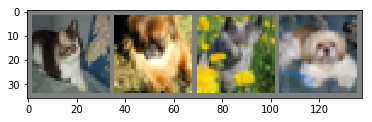

GroundTruth:   plane   car plane   car


NameError: name 'outputs' is not defined

In [123]:
images, labels = test_data_iter.next()

# print images
imshow(torchvision.utils.make_grid(images))
plt.show()

print('GroundTruth:  ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

_, predicted = torch.max(outputs.data, 1)
print('Predicted:    ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Let us look at how the network performs on the whole dataset.

In [124]:
correct = 0
total = 0

for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the {} test images: {:4.2f} %'.format(
    testset.test_data.shape[0], 100 * correct / total))

RuntimeError: Given groups=1, weight of size 16 32 5 5, expected input[4, 3, 32, 32] to have 32 channels, but got 3 channels instead

Hopefully the network is better than chance, which is $\frac{1}{\text{number of classes}}$ accuracy (randomly picking
a class).


We can also examine which class the network found the most difficult (makes more sense if you have many clases):

In [125]:
class_total = list(0. for i in range(len(classes)))
class_correct = list(0. for i in range(len(classes)))

for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    
    for i in range(len(c)):
        label = labels[i]
        class_correct[label] += c[i].numpy()
        class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of {:5s} : {:5.2f} %'.format(
        classes[i], 100 * class_correct[i] / class_total[i]))

RuntimeError: Given groups=1, weight of size 16 32 5 5, expected input[4, 3, 32, 32] to have 32 channels, but got 3 channels instead

**Assignment 4:** 
1. Go back and improve performance of the network. 
 * If you are using all 10 classes you should get a test accuracy above 55%, but see how much further you can get it!
 * If you are using only 2 classes (e.g. cat and dog) you should get a test accuracy above 60%, but see how much further you can get it!

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?

3. Write down key lessons/insights you got (if any) during this exercise.

**Answer:**

# Training on GPU

**Optional Assignment:**
If you have a GPU we suggest that you try and rewrite the code above to run on the GPU
___

Just like how you transfer a Tensor on to the GPU, you transfer the neural net onto the GPU.
This will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

```
    net.cuda()
```

Remember that you will have to send the inputs and targets at every step to the GPU too:

```
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
```

Why dont I notice MASSIVE speedup compared to CPU? 
Because your network is realllly small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images




# Michael Nielsen book exercise of own choice







**Assignment 5:** Pick an exercise of own choice from [Michael Nielsens book](http://neuralnetworksanddeeplearning.com/)

This is the first exercise of the first chapter

Prompt:\
Suppose we take all the weights and biases in a network of perceptrons, and multiply them by a positive constant, c>0. Show that the behaviour of the network doesn't change.


**Answer:**
Perceptrons can only ever output 0 or 1, depending on whether the input vector times the weight plus the bias is positive or zero or smaller than zero. This expression can be written as
$$c⋅w⋅x + c⋅b$$
where w is the weights, x is the input vector, b is the bias and c is the positive constant. This can easily be rewritten as 
$$c * (⋅w⋅x + b)$$
Now, it should be clear that the output of any perceptron cannot change as the strictly positive constant c cannot change the sign, which is all that matters for the perceptron.

